In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import os, time, random, math, re, json, string, sys, datetime, textwrap
import matplotlib.pyplot as plt
from tqdm import tqdm
from tokenizer import tokenizer, detokenizer
from MyModel import MyModel, OneStep
import keras.backend as K
import tensorflow_model_optimization as tfmot

In [3]:
# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

policy = tf.keras.mixed_precision.global_policy()

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


In [4]:
# gpu growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Dataset
all_text = open("tmp/posts.txt", 'rb').read().decode(encoding='utf-8')
all_text = all_text[:10_000_000]

len(all_text), all_text[:100], len(all_text.split("<SPECIAL:END>"))

(10000000,
 "I am a third year (starting fourth year in the fall) PhD student in mathematics. I've passed all qua",
 9134)

In [6]:
all_tokens = tokenizer(all_text)
alltokens100k = all_tokens[:500_000]
# vocab = list(set(all_tokens[:500_000]))
# vocab = list(sorted(vocab, key=alltokens100k.count, reverse=True))
vocab = json.load(open("models/vocab.json", 'r'))
print(len(vocab))

5002


In [7]:
# create tokens to ids and ids to tokens, vocab is sorted by frequency
text_vectorization = tf.keras.layers.TextVectorization(
    standardize=None,
    split=None,
    vocabulary=vocab[:5000]
)

In [8]:
print("vocab size", len(text_vectorization.get_vocabulary()))
# The maximum length sentence we want for a single input in characters
seq_length = 150
all_ids = text_vectorization(all_tokens)
ds = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = ds.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

ds = sequences.map(split_input_target)

# Batch size
BATCH_SIZE = 256
ds = ds.repeat(-1).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

vocab size 5000


In [9]:
for example in ds.take(1):
    print(detokenizer(np.array(text_vectorization.get_vocabulary())[example[0][0].numpy()]))


I'm looking for a lot in an answer. It should:

be short
open the [UNK] person's eyes
allow for a [UNK] exit by both parties

Here is an example of the kind of answer I'm looking for:

Question posed by a white person to a [UNK] black [UNK]:" What country were you born in?"
Answer:" Long [unk]."

Edit: Please assume there was no hidden [UNK]. Just some combination of [UNK] variety [UNK] and [UNK] thinking.
Typical scenarios: [UNK] [UNK]... parent meeting at your [UNK] school... standing in line at the [UNK] store....
Edit 9 / 18:


In [10]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(text_vectorization.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 2048

model = MyModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)
model.build(tf.TensorShape([None, None]))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1280000   
                                                                 
 lstm (LSTM)                 multiple                  18882560  
                                                                 
 dense (Dense)               multiple                  10245000  
                                                                 
Total params: 30,407,560
Trainable params: 30,407,560
Non-trainable params: 0
_________________________________________________________________


In [11]:
model(tf.constant([[1, 2, 3]]))

<tf.Tensor: shape=(1, 3, 5000), dtype=float32, numpy=
array([[[-1.2481312e-03,  5.1734853e-05,  7.7220460e-04, ...,
          1.3093359e-03,  7.3006219e-04,  2.5928987e-03],
        [ 2.8894821e-04, -6.5484259e-04, -7.7146059e-04, ...,
         -1.1503412e-03,  4.4443540e-04,  1.9332578e-03],
        [-9.7052840e-04, -8.2985597e-04,  2.5322498e-04, ...,
         -1.0170377e-03, -4.9060740e-04,  2.7268527e-03]]], dtype=float32)>

In [12]:

for input_example_batch, target_example_batch in ds.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

model.summary()

(256, 150, 5000) # (batch_size, sequence_length, vocab_size)
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1280000   
                                                                 
 lstm (LSTM)                 multiple                  18882560  
                                                                 
 dense (Dense)               multiple                  10245000  
                                                                 
Total params: 30,407,560
Trainable params: 30,407,560
Non-trainable params: 0
_________________________________________________________________


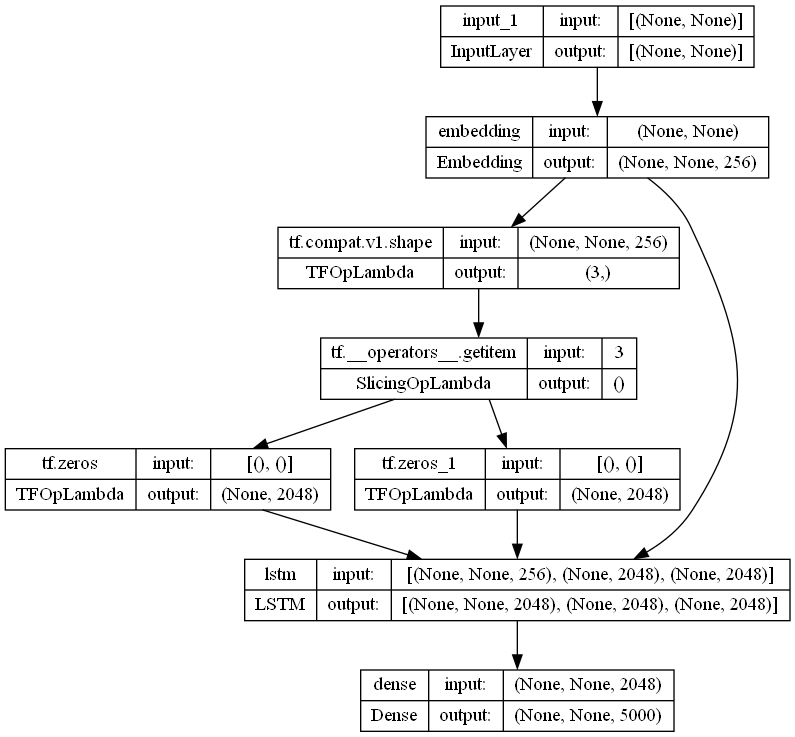

In [13]:
# does not work so this is a hack
def plot_model_works(model):
    # inp is cop of input_example_batch
    inp = tf.keras.layers.Input(shape=[None], dtype=tf.int64)
    model1 = tf.keras.Model(inp, model.call(inp))
    return tf.keras.utils.plot_model(model1, show_shapes=True)


plot_model_works(model)

In [14]:
model.layers[0].dtype, model.layers[1].dtype, model.layers[2].dtype

('float32', 'float32', 'float32')

In [15]:
print("Input:\n", detokenizer(np.array(text_vectorization.get_vocabulary())[input_example_batch[0].numpy()]))
print()
print("Next Char Predictions:\n", detokenizer(np.array(text_vectorization.get_vocabulary())[np.argmax(example_batch_predictions[0], axis=-1)]))

Input:
 Done with my current field? If not, how can one deal with the impression of failure and regret?

(English is not my first language, any edits are [UNK] welcomed) <SPECIAL:END> There is an [UNK] sharing the office with me. Once day his Pi came to talk to him. Since there were only 3 of us in the office, although I didn't pay attention, their conversation just automatically went into my mind.

The story is like this: the [UNK] had worked for 2 months, and he was going to leave. However, he would not let the university know that he was leaving. Instead, the Pi would tell the university that the [UNK] would work for another month.

Next Char Predictions:
 Subfield 25 push refrain bound bound bound itself entirely everyone direction water departmental youtube min collaborating sexual meetings content handwritten was ask course mentioning course reviewer's “ “ “ serving tax researcher r luck i've i've scientists amazon count wait undergrads exception non seemingly india note failed f

In [16]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(labels, logits):
    # scce but capped at 2000.0 to avoid exploding gradients
    loss_val = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    loss_val = tf.clip_by_value(loss_val, clip_value_min=-1000.0, clip_value_max=2000.0)
    return tf.reduce_mean(loss_val)


example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)
print("Exp of mean loss: ", np.exp(example_batch_mean_loss))
print("Vocab size:       ", vocab_size)

optimizer = tf.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(0.003, 300, 0.95))

model.compile(optimizer=optimizer, loss=loss)

Prediction shape:  (256, 150, 5000)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(8.517181, shape=(), dtype=float32)
Exp of mean loss:  4999.941
Vocab size:        5000


In [34]:
# Directory where the checkpoints will be saved
checkpoint_dir = './tmp/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


# Set epochs to 50 and steps_per_epoch to 600 to replicate the results
history = model.fit(ds, epochs=1, steps_per_epoch=10, callbacks=[checkpoint_callback])

10/10 [==============================] - 17s 2s/step - loss: 0.6322


In [35]:
# model.save_weights("tmp/weights3.h5")

In [36]:
# model.load_weights("tmp/weights2.h5")
# model.load_weights("models/model1-test2-backup/weights.h5")

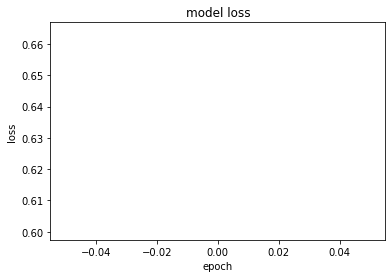

In [37]:
# plot loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [38]:
model.evaluate(ds, steps=20)

20/20 [==============================] - 12s 511ms/step - loss: 0.8702


0.8701754808425903

In [39]:
one_step_model = OneStep(model)

OneStep.__init__


In [40]:
MODEL_NAME = "models/model1-test2"

# make sure the directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

model.save_weights(f"{MODEL_NAME}/weights.h5")

with open(f"{MODEL_NAME}/vocab.json", "w") as f:
    f.write(json.dumps(text_vectorization.get_vocabulary()))

with open(f"{MODEL_NAME}/meta.json", "w") as f:
    f.write(json.dumps({
        "embedding_dim": embedding_dim,
        "rnn_units": rnn_units,
        "vocab_size": vocab_size,
    }))

In [41]:
def generate_text(starting, num_generate):
    start = time.time()
    states = None
    next_char = text_vectorization(tokenizer(starting))
    result = next_char.numpy()

    for n in tqdm(range(num_generate)):
        next_char = tf.expand_dims(next_char, 0)
        next_char, states = one_step_model.generate_one_step(next_char, states=states, temperature=0.7)
        result = np.append(result, next_char.numpy(), axis=0)
    result = detokenizer([text_vectorization.get_vocabulary()[r] for r in result])
    end = time.time()
    print()
    print(result)
    print("-" * 80)
    w = textwrap.TextWrapper(width=90,break_long_words=True,replace_whitespace=False)
    print(w.fill(result))
    print("\nRun time:", end - start)

generate_text("I recently published my", 100)

100%|██████████| 100/100 [00:01<00:00, 68.66it/s]



I recently published my first research paper and it was accepted in a peer-reviewed journal in the field of Ai. I worked in private engineering in Europe (mostly in area, linear algebra, coding, and field topics that I have never seen on a topic that is required in the field on research and also engineering). I am worried about the quality of the world at the moment, but I know that this source of my ability of doing research is for all of those fields, being a big"
--------------------------------------------------------------------------------
I recently published my first research paper and it was accepted in a peer-reviewed
journal in the field of Ai. I worked in private engineering in Europe (mostly in area,
linear algebra, coding, and field topics that I have never seen on a topic that is
required in the field on research and also engineering). I am worried about the quality of
the world at the moment, but I know that this source of my ability of doing research is
for all of tho

In [42]:
len(text_vectorization.get_vocabulary())

5000